In [118]:
import requests
import pandas as pd

api_key = 'ITL1B9MC4L5G7SEN'
symbol = 'SIE.DE'
output_size = 'full'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={api_key}'
r = requests.get(url)
time_series = r.json()['Time Series (Daily)']

data = []
for date, values in time_series.items():
    data.append([
        date,
        float(values["1. open"]),
        float(values["2. high"]),
        float(values["3. low"]),
        float(values["4. close"]),
        int(values["5. volume"])
    ])

df0 = pd.DataFrame(data, columns=["date", "open", "high", "low", "close", "volume"])
print(df0.shape)
df0.head(15)

(4943, 6)


,date,open,high,low,close,volume
0,2024-06-14,170.80,171.10,165.68,165.74,1686923
1,2024-06-13,177.28,177.56,170.44,170.84,1395794
2,2024-06-12,173.12,178.58,172.30,178.10,975006
3,2024-06-11,174.70,175.44,172.18,172.46,953042
4,2024-06-10,174.12,174.52,172.06,174.44,717411
5,2024-06-07,175.00,175.26,172.62,174.44,1034765
6,2024-06-06,178.88,179.52,175.14,175.68,826573
7,2024-06-05,175.60,178.82,175.38,178.82,828300
8,2024-06-04,178.58,179.00,174.28,174.28,1232510
9,2024-06-03,178.80,179.60,177.10,178.16,745486


In [119]:
import pandas_ta as pta
import ta

df = df0.copy()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df['RSI'] = pta.rsi(df['close'], length=11)
df['William%R'] = pta.willr(df['high'], df['low'], df['close'], length=11)
df['WMA'] = pta.wma(df['close'], length=11)
df['EMA'] = pta.ema(df['close'], length=11)
df['SMA'] = pta.sma(df['close'], length=11)
df['HMA'] = pta.hma(df['close'], length=11)
df['CCI'] = pta.cci(df['high'], df['low'], df['close'], length=11)
df['CMO'] = pta.cmo(df['close'], length=11)

macd = pta.macd(df['close'])
df['MACD'] = macd.iloc[:, 0] 
df['MACD_signal'] = macd.iloc[:, 1] 

ppo = pta.ppo(df['close'])
df['PPO'] = ppo.iloc[:, 0] 
df['PPO_signal'] = ppo.iloc[:, 1]

df['ROC'] = pta.roc(df['close'], length=11)
df['CMFI'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=11).chaikin_money_flow()

dmi = pta.adx(df['high'], df['low'], df['close'], length=11)
df['DMI'] = dmi['ADX_11']
df['DI+'] = dmi['DMP_11']
df['DI-'] = dmi['DMN_11']

df['PSI'] = pta.pvt(df['close'], df['volume'])
df['TripleEMA'] = pta.ema(df['close'], length=11)

def label_data(data, window_size=11):
    data['Label'] = 'Hold'
    for i in range(window_size, len(data) - window_size):
        window = data['Close'].iloc[i-window_size:i+window_size]
        min_index = window.idxmin()
        max_index = window.idxmax()
        if i == min_index:
            data.at[i, 'Label'] = 'Buy'
        elif i == max_index:
            data.at[i, 'Label'] = 'Sell'
    return data

df = df.dropna()

for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

df = df.drop(columns=['MACD_signal', 'PPO_signal', 'DI+', 'DI-'])

print(df.info())
df.head(15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4910 entries, 2024-04-29 to 2005-01-03
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4910 non-null   float64
 1   high       4910 non-null   float64
 2   low        4910 non-null   float64
 3   close      4910 non-null   float64
 4   volume     4910 non-null   float64
 5   RSI        4910 non-null   float64
 6   William%R  4910 non-null   float64
 7   WMA        4910 non-null   float64
 8   EMA        4910 non-null   float64
 9   SMA        4910 non-null   float64
 10  HMA        4910 non-null   float64
 11  CCI        4910 non-null   float64
 12  CMO        4910 non-null   float64
 13  MACD       4910 non-null   float64
 14  PPO        4910 non-null   float64
 15  ROC        4910 non-null   float64
 16  CMFI       4910 non-null   float64
 17  DMI        4910 non-null   float64
 18  PSI        4910 non-null   float64
 19  TripleEMA  4910 non-null   flo

,open,high,low,close,volume,RSI,William%R,WMA,EMA,SMA,HMA,CCI,CMO,MACD,PPO,ROC,CMFI,DMI,PSI,TripleEMA
date,,,,,,,,,,,,,,,,,,,,
2024-04-29,3.076558,3.043858,3.092136,3.050147,-1.005469,0.029870,-0.774977,3.092911,3.082873,3.160439,2.934508,-0.360760,0.029870,0.818661,0.725794,-0.867154,0.593130,0.008023,-1.165691,3.082873
2024-04-26,2.963077,3.014868,2.982005,3.049468,-0.845337,0.026385,-0.779657,3.072712,3.076234,3.136978,2.953291,-0.487545,0.026385,0.707791,0.528790,-0.661845,1.416329,0.045257,-1.165778,3.076234
2024-04-25,2.951525,2.913741,2.909497,2.916455,-0.787360,-0.594655,-1.350263,3.034277,3.048549,3.093012,2.952033,-0.998797,-0.594655,0.428106,0.368749,-1.235735,1.475481,0.143473,-1.185216,3.048549
2024-04-24,2.960359,2.969024,2.973113,2.948351,-0.795461,-0.399684,-0.967255,3.008489,3.030790,3.050646,2.944068,-0.647311,-0.399684,0.249877,0.155636,-1.187467,0.676465,0.132887,-1.180532,3.030790
2024-04-23,2.948807,2.934641,2.960116,2.972104,-0.841508,-0.252206,-0.693016,2.993725,3.019946,3.023737,2.938124,-0.639262,-0.252206,0.141782,-0.059429,-0.766367,0.770860,0.136656,-1.177409,3.019946
2024-04-22,2.959679,2.940708,2.962168,2.927313,-0.921940,-0.473476,-0.880974,2.975991,3.003450,3.000461,2.926844,-0.642100,-0.473476,-0.005950,-0.216458,-0.670062,0.627685,0.128352,-1.182139,3.003450
2024-04-19,2.894445,2.856436,2.906761,2.891346,-0.632314,-0.645725,-1.228159,2.956152,2.983713,2.978355,2.905932,-1.096268,-0.645725,-0.170719,-0.329235,-0.640788,0.321716,0.181649,-1.189275,2.983713
2024-04-18,2.982104,2.981833,2.992266,2.978211,-0.803356,-0.062907,0.134007,2.954467,2.981733,2.966532,2.909516,0.232162,-0.062907,-0.175248,-0.381294,-0.336813,0.049734,0.004562,-1.176683,2.981733
2024-04-17,2.896483,2.903628,2.923178,2.881845,-0.973529,-0.539043,-1.303704,2.938706,2.964034,2.951322,2.903274,-0.842228,-0.539043,-0.310324,-0.458987,-0.442311,-0.282494,-0.071582,-1.185284,2.964034


In [120]:
def label_data(prices, window_size=11):
    labels = ['hold'] * len(prices)
    half_window = window_size // 2
    
    for i in range(half_window, len(prices) - half_window):
        window = prices[i - half_window: i + half_window + 1]
        if prices[i] == max(window):
            labels[i] = "sell"
        elif prices[i] == min(window):
            labels[i] = "buy"
    
    return labels


df['label'] = label_data(df['close'])

df.sample(15)

/tmp/ipykernel_68178/2464335656.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if prices[i] == max(window):
/tmp/ipykernel_68178/2464335656.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif prices[i] == min(window):


,open,high,low,close,volume,RSI,William%R,WMA,EMA,SMA,...,CCI,CMO,MACD,PPO,ROC,CMFI,DMI,PSI,TripleEMA,label
date,,,,,,,,,,,,,,,,,,,,,
2023-06-28,2.419455,2.393947,2.174151,2.204564,-0.466304,1.028094,0.487092,2.060881,2.075366,2.017501,...,1.436497,1.028094,0.774857,-0.416931,0.259002,-0.599513,0.111623,-1.234498,2.075366,hold
2019-07-15,0.080245,0.070209,0.078185,0.073660,-0.657526,1.135552,-0.990915,0.081724,0.052019,0.090194,...,-0.436604,1.135552,1.340798,2.251490,0.037456,-0.358712,1.512504,-0.262827,0.052019,hold
2023-06-07,2.410621,2.379789,2.384152,2.399333,-0.903765,0.296753,-1.079314,2.485184,2.442538,2.503285,...,-0.877704,0.296753,1.892884,1.604123,-0.195503,-1.775948,0.558856,-1.181084,2.442538,hold
2015-02-03,-0.065853,-0.050735,-0.035892,-0.040741,0.062677,-0.176629,1.268594,-0.065176,-0.052542,-0.069174,...,0.970259,-0.176629,-0.529232,-0.605100,-0.118529,1.137967,0.973815,-0.013049,-0.052542,hold
2010-07-29,-0.695405,-0.708221,-0.753573,-0.771635,0.307176,-0.323767,-1.258379,-0.712992,-0.727040,-0.710793,...,-0.712390,-0.323767,0.242356,0.912423,-0.111482,-0.285176,-0.672620,0.731087,-0.727040,buy
2009-03-23,-1.638036,-1.629894,-1.631658,-1.615216,0.510694,0.253849,0.744272,-1.660762,-1.651319,-1.661110,...,0.713439,0.253849,-0.532288,-1.167112,0.769544,0.935319,-0.822383,-0.657581,-1.651319,sell
2016-10-21,0.273510,0.256482,0.293700,0.278602,-0.571579,0.501823,1.172754,0.234455,0.237923,0.197161,...,0.828578,0.501823,-0.364178,-0.562333,0.576122,-0.643456,0.012816,0.227464,0.237923,hold
2012-03-08,-0.785334,-0.780365,-0.771498,-0.763630,0.081239,-0.399607,-1.106754,-0.715272,-0.722897,-0.692208,...,-0.877881,-0.399607,0.578641,0.775341,-0.552721,1.882703,1.151544,-0.113416,-0.722897,hold
2022-10-27,0.812372,0.813666,0.801277,0.829643,-0.739150,-1.034897,-0.492361,0.817748,0.889839,0.858860,...,-0.219024,-1.034897,-3.093011,-2.399206,-1.381774,0.526961,2.664319,-1.533845,0.889839,hold


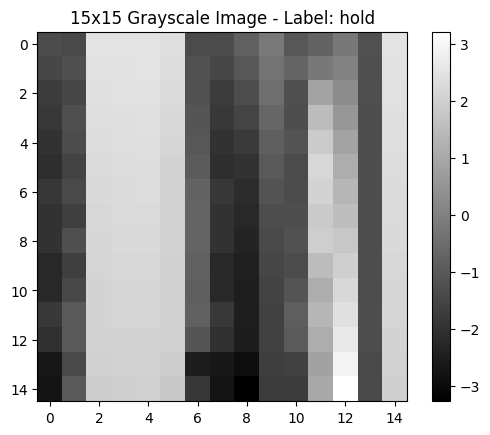

In [128]:
import matplotlib.pyplot as plt

def create_image(df, start_idx, end_idx):
    image_data = df.iloc[start_idx:end_idx, 5:20].values
    central_label = df.iloc[(start_idx + end_idx) // 2]['label']
    
    if image_data.shape != (15, 15):
        raise ValueError("Data for image is not 15x15")
    
    return image_data, central_label

def display_image(image_data, label):
    plt.imshow(image_data, cmap='gray', aspect='equal')
    plt.colorbar()
    plt.title(f"15x15 Grayscale Image - Label: {label}")
    plt.show()

image, label = create_image(df, 200, 215)
display_image(image, label)

# def generate_images(df, window_size=15):
#     images = []
#     labels = []
#     for i in range(len(df) - window_size + 1):
#         image, label = create_image(df, i, i + window_size)
#         images.append(image)
#         labels.append(label)
#     return images, labels

# images, labels = generate_images(df)

# print(images[0])